In [10]:
import numpy as np
import pandas as pd

In [11]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv'

In [12]:
!curl $data > data.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  853k  100  853k    0     0   940k      0 --:--:-- --:--:-- --:--:--  940k


# data preparation

In [13]:
df = pd.read_csv('data.csv')

In [14]:
df = df[['engine_displacement','horsepower','vehicle_weight','model_year',
    'fuel_efficiency_mpg']]

In [15]:
df.head()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369


# eda

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

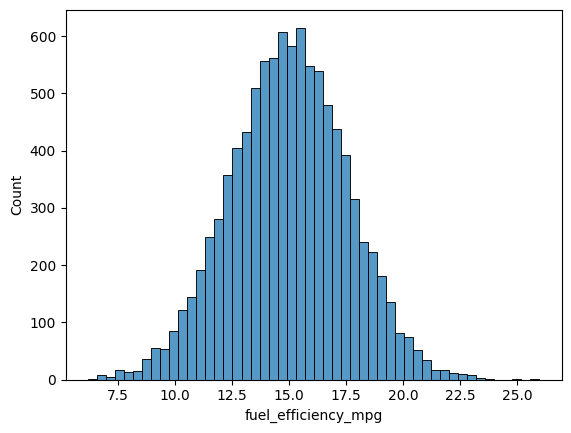

In [17]:
sns.histplot(df.fuel_efficiency_mpg,bins=50)

In [18]:
df.isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

In [19]:
df.horsepower.median()

np.float64(149.0)

In [20]:
n = len(df)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val- n_test

In [21]:
n, n_val, n_test, n_train

(9704, 1940, 1940, 5824)

In [22]:
idx = np.arange(n)
idx

array([   0,    1,    2, ..., 9701, 9702, 9703], shape=(9704,))

In [23]:
np.random.seed(42)
np.random.shuffle(idx)

In [24]:
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_val+n_train]]
df_test = df.iloc[idx[n_val+n_train:]]

In [25]:
# filling with zero the missing values
df_train_zero = df_train.fillna(0)

In [26]:
# filling with mean the missing values
df_train_mean = df_train.fillna(df_train.horsepower.mean())

In [27]:
y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

In [28]:
del df_train['fuel_efficiency_mpg']
del df_train_zero['fuel_efficiency_mpg']
del df_train_mean['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']

# linear regression

In [29]:
def train_linear_regression(X,y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

In [30]:
def prepare_X_z(df):
    df = df.fillna(0)
    X = df.values
    return X

In [31]:
def prepare_X_mean(df):
    df = df.fillna(df.horsepower.mean())
    X = df.values
    return X

In [32]:
def rmse(y, y_pred):
    error = y - y_pred
    se = error ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [33]:
# trian with X_trian_0 first 
X_train_zero = prepare_X_z(df_train)
w0 ,w = train_linear_regression(X_train_zero, y_train)

X_val_zero = prepare_X_z(df_val)
y_pred_zero = w0 + X_val_zero.dot(w)

rmse(y_val, y_pred_zero)

np.float64(0.5173782638844466)

In [34]:
# now train with mean for miising values
X_train_mean = prepare_X_mean(df_train)
w0 ,w = train_linear_regression(X_train_mean, y_train)

X_val_mean = prepare_X_mean(df_val)
y_pred_mean = w0 + X_val_mean.dot(w)

rmse(y_val, y_pred_mean)


np.float64(0.4636236995020941)

In [35]:
car = df_test.iloc[20].to_dict()
car

{'engine_displacement': 160.0,
 'horsepower': 125.0,
 'vehicle_weight': 3317.04204639791,
 'model_year': 2018.0}

In [36]:
df_small = pd.DataFrame([car])
df_small

,engine_displacement,horsepower,vehicle_weight,model_year
0,160.0,125.0,3317.042046,2018.0


In [37]:
X_small_z = prepare_X_z(df_small)

In [38]:
y_pred_z = w0 + X_small_z.dot(w)
y_pred_z

array([13.14032855])

In [39]:
X_small_m = prepare_X_mean(df_small)

In [40]:
y_pred_m = w0 + X_small_m.dot(w)
y_pred_m

array([13.14032855])

In [41]:
test = y_test[20]

In [42]:
pred = y_pred_m

In [43]:
print("rmse") 
print(abs(test-pred)**0.5)

rmse
[0.60105928]


# regularization

In [44]:
def train_linear_regression_reg(X,y,r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

In [45]:
X_train = prepare_X_z(df_train)
w0 ,w = train_linear_regression_reg(X_train, y_train, r = 0.01)

X_val = prepare_X_z(df_val)
y_pred = w0 + X_val.dot(w)
rmse(y_val, y_pred)

np.float64(0.5171115525769823)

In [46]:
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    X_train = prepare_X_z(df_train)
    w0 ,w = train_linear_regression_reg(X_train, y_train, r = r)

    X_val = prepare_X_z(df_val)
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    print(r,w0, round(score,4))

0 28.82736547365895 0.5174
0.01 24.92683841981215 0.5171
0.1 11.239661084581073 0.5188
1 1.7315979411219746 0.5222
5 0.3638075020482907 0.5229
10 0.18306246621686947 0.523
100 0.01841801730688404 0.5231


In [ ]:
seeds = list(range(10))
scores =  []
n = len(df)
X = df
y = df.fuel_efficiency_mpg

del X['fuel_efficiency_mpg']

In [61]:
for seed in seeds:
    np.random.seed(seed)

    idx = np.arange(n)
    np.random.shuffle(idx)

    n_val = int(n * 0.2)
    n_test = int(n * 0.2)
    n_train = n - n_val- n_test
    
    train_idx = idx[:n_train]
    val_idx = idx[n_train:n_train + n_val]
    test_idx = idx[n_train + n_val:]

    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.loc[val_idx], y.iloc[val_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)
    X_val = X_val.fillna(0)
    
    w0 , w = train_linear_regression(X_train, y_train)
    
    y_pred = w0 + X_val.dot(w)
    # print(y_pred)
    print(rmse(y_val, y_pred))
    score = rmse(y_val, y_pred)
    scores.append(score)

    

0.5206531296294218
0.521338891285577
0.5228069974803171
0.515951674119676
0.5109129460053851
0.52834064601107
0.5313910658146311
0.5090670387381733
0.5147399129511132
0.5131865908224594


In [65]:
std = np.std(scores)
std

np.float64(0.006989446426433706)

In [70]:
np.random.seed(9)

idx = np.arange(n)
np.random.shuffle(idx)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val- n_test

train_idx = idx[:n_train]
val_idx = idx[n_train:n_train + n_val]
test_idx = idx[n_train + n_val:]

X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
X_val, y_val = X.loc[val_idx], y.iloc[val_idx]
X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
X_val = X_val.fillna(0)

In [71]:
X_full_train = pd.concat([X_train, X_val])
X_full_train = X_full_train.fillna(0)
y_full_train = np.concatenate([y_train, y_val])

In [81]:
w0, w = train_linear_regression_reg(X_full_train, y_full_train, r=0.001)

In [82]:
y_pred = w0 + X_test.dot(w)
score = rmse(y_test, y_pred)
score

np.float64(0.5156261299169602)

In [83]:
car = X_test.iloc[60].to_dict()
car

{'engine_displacement': 180.0,
 'horsepower': 121.0,
 'vehicle_weight': 3295.310679583003,
 'model_year': 2002.0}

In [84]:
X_small = pd.DataFrame([car])
X_small

,engine_displacement,horsepower,vehicle_weight,model_year
0,180.0,121.0,3295.31068,2002.0


In [85]:
X_small = X_small.fillna(0)

In [86]:
y_pred = w0 + X_small.dot(w)
y_pred

0    13.433485
dtype: float64

In [89]:
test = y_test.iloc[60]
test

np.float64(13.49995260921676)

In [91]:
pred = y_pred
pred

0    13.433485
dtype: float64

In [92]:
print("rmse :")
abs(test - pred)**0.5

rmse :


0    0.257813
dtype: float64